# Jan Izydorczyk
# Sprawozdanie 7

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import random
import scipy
import sys
%matplotlib notebook

print("Wersja Pythona:")
print (sys.version)
print(f"Wersja numpy: {np.__version__}")
print("Konfiguracja liczb zmiennoprzecinkowych")
print(sys.float_info)

f64 = np.float64
f32 = np.float32

Wersja Pythona:
3.9.4 (tags/v3.9.4:1f2e308, Apr  6 2021, 13:40:21) [MSC v.1928 64 bit (AMD64)]
Wersja numpy: 1.20.2
Konfiguracja liczb zmiennoprzecinkowych
sys.float_info(max=1.7976931348623157e+308, max_exp=1024, max_10_exp=308, min=2.2250738585072014e-308, min_exp=-1021, min_10_exp=-307, dig=15, mant_dig=53, epsilon=2.220446049250313e-16, radix=2, rounds=1)


In [2]:
from scipy.linalg import lu_factor, lu_solve
from itertools import chain, product
from timeit import timeit
import pandas as pd
from mpmath import nstr, mpf

# Zadanie 1

In [172]:
def eig_(method):
    def wrapper(M, *args, x_0=None, epsilon=None, max_steps=None, epsilon_buff=None, **kwargs):
        
        def pred(x_t1, x_t, steps):
            nonlocal max_steps, epsilon
            res = True
            if epsilon is not None:
                if steps > 2e4:
                    print('Overflow')
                    print('----')
                    print(np.linalg.norm(x_t1 - x_t))
                    print('----')
                    return False
                res =  np.linalg.norm(x_t1 - x_t) > epsilon and np.linalg.norm(x_t1 + x_t) > epsilon
            elif max_steps is not None:
                res = steps < max_steps
            else:
                res = False
            if epsilon is not None and epsilon_buff is not None:
                epsilon_buff.append(np.mean(np.abs(x_t - x_t1)))
            return res
        if x_0 is None:
            x_0 = np.random.rand(M.shape[0], 1)
        else:
            x_0 = np.copy(x_0)
            
        return method(M, *args, x_0=x_0, epsilon=epsilon, max_steps=max_steps, pred=pred, **kwargs)
    return wrapper

## Metoda potęgowa

In [173]:
@eig_
def power_method(M, x_0=None, epsilon=None, max_steps=None, pred=None):
    x_t = x_0
    steps = 0
    x = x_t + 2
    
    while pred(x_t, x, steps):
        steps += 1
        x = x_t
        x_t = M @ x_t
        idx = np.argmax(np.abs(x_t))
        max_val = x_t[idx, 0]
        x_t /= max_val
    return max_val, x_t / np.linalg.norm(x_t)
        

In [5]:
def rand_symm(N):
    M = np.random.rand(N, N)
    return (M + M.T) / 2

In [6]:
n_tests = 40
epsilon = 1e-4

all_correct = True

for _ in range(n_tests):
    M = rand_symm(random.randint(4, 20))
    own_eig, own_eig_vec = power_method(M, epsilon=epsilon)
    own_eig_vec = own_eig_vec.flatten()
    
    np_eig, np_eig_vec = np.linalg.eig(M)
    np_eig, np_eig_vec = np_eig[0], np_eig_vec[:, 0].flatten()
    eig_not_cor = abs(np_eig - own_eig) > epsilon * 10
    diffs = np.abs(np_eig_vec-own_eig_vec)
    sums = np.abs(np_eig_vec+own_eig_vec)
    sum_not_cor = not np.allclose(sums, 0, atol=epsilon)
    diff_not_cor = not np.allclose(diffs, 0, atol=epsilon)
    if eig_not_cor or (sum_not_cor and diff_not_cor):
        all_correct = False
        break

print(all_correct)


True


## Testy czasowe

In [47]:
data = []

names = ['Equation', 'A1', 'A2', 'A3']

funs = [np.linalg.eig, lambda A: power_method(A, epsilon=1e-6)]
names = ['np.linalg.solve', 'power_method']

ns = range(100, 2500, 100)

for n in ns:
    d = [f'{n}']
    M = rand_symm(n)
    for f, name in zip(funs, names):
        t = timeit(lambda: f(M), number=10)* 1000
        d += [name, nstr(mpf(t), 3)]
    data.append(d)

pd.DataFrame(data, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]'])

,n,Function,Time[ms],Function,Time[ms]
0,100,np.linalg.solve,82.2,power_method,7.84
1,200,np.linalg.solve,615.0,power_method,7.02
2,300,np.linalg.solve,1.24e+3,power_method,7.56
3,400,np.linalg.solve,2.14e+3,power_method,6.92
4,500,np.linalg.solve,3.41e+3,power_method,8.28
5,600,np.linalg.solve,5.11e+3,power_method,12.7
6,700,np.linalg.solve,7.17e+3,power_method,16.7
7,800,np.linalg.solve,9.89e+3,power_method,20.8
8,900,np.linalg.solve,1.27e+4,power_method,26.8
9,1000,np.linalg.solve,1.71e+4,power_method,42.0


Metoda biblioteczna jest znacząco wolniejsza od metody potegowej. Wynika to z tego, że metoda biblioteczna wylicza wszystkie wartości własne macierzy, a nie tylko dominującą. Jest to znacznie trudniejsze zadanie. 

Należy jednak zauważyć, że funkcja biblioteczna średnio szybciej wylicza pojednyńcze wartości własne.

In [64]:
data_pow = pd.DataFrame(data, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]']).to_numpy()
data_pow[:, [0, 2, 4]] = data_pow[:, [0, 2, 4]].astype(f64)
data_pow = np.c_[data_pow, data_pow[:, 2] / data_pow[:, 0]]

In [68]:
pd.DataFrame(data_pow, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]', 'Time[ms] per n'])

,n,Function,Time[ms],Function,Time[ms],Time[ms] per n
0,100.0,np.linalg.solve,82.2,power_method,7.84,0.822
1,200.0,np.linalg.solve,615.0,power_method,7.02,3.075
2,300.0,np.linalg.solve,1240.0,power_method,7.56,4.133333
3,400.0,np.linalg.solve,2140.0,power_method,6.92,5.35
4,500.0,np.linalg.solve,3410.0,power_method,8.28,6.82
5,600.0,np.linalg.solve,5110.0,power_method,12.7,8.516667
6,700.0,np.linalg.solve,7170.0,power_method,16.7,10.242857
7,800.0,np.linalg.solve,9890.0,power_method,20.8,12.3625
8,900.0,np.linalg.solve,12700.0,power_method,26.8,14.111111
9,1000.0,np.linalg.solve,17100.0,power_method,42.0,17.1


<IPython.core.display.Javascript object>


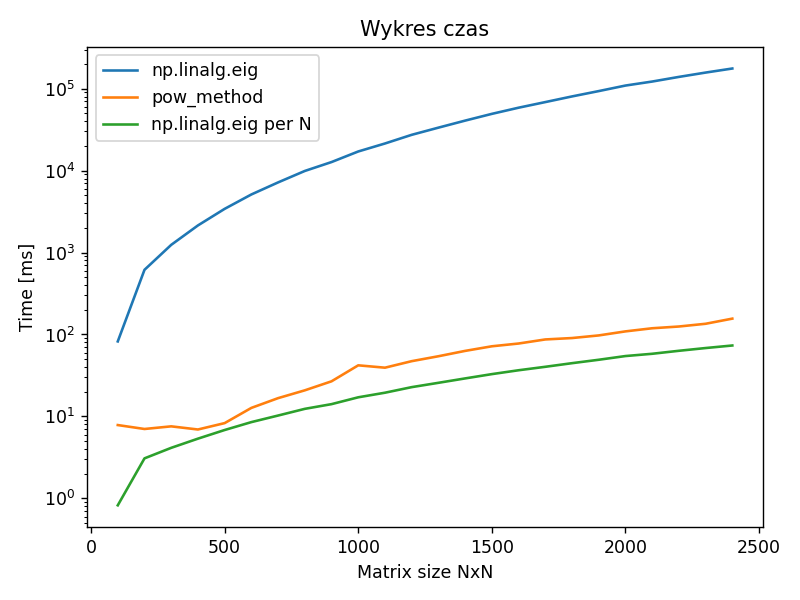

In [74]:
fig = plt.figure()
plt.plot(data_pow[:, 0], data_pow[:, 2], label='np.linalg.eig')
plt.plot(data_pow[:, 0], data_pow[:, 4], label='pow_method')
plt.plot(data_pow[:, 0], data_pow[:, 5], label='np.linalg.eig per N')
plt.yscale('log')
plt.title('Wykres czas')
plt.xlabel('Matrix size NxN')
plt.ylabel('Time [ms]')
plt.legend()
fig.tight_layout()
plt.show()

### Dlaczego to działa?
1. Z odpowiedniej matematyki wiemy, że te kolejne wektory zbiegają do wektora własnego odpowiadającego największej wartości własnej.
2. "Normalizowanie" wektorów jest dalej ok, bo jeżeli $M \cdot x = \sigma x $, to dla $ y = \alpha x $ mamy $ M \cdot (y) = M \cdot (\alpha x) = \alpha \cdot M \cdot  x = \alpha (\sigma x) = \sigma(\alpha x) = \sigma y $ czyli $y$ to dalej wektor własny dla wartości własnej $\sigma$.

## Odwrotna przesunięta metoda potęgowa

Macierz $M = (A−σI)^{-1}$ (jeśli istnieje), to ma wartości własne równe $\frac{1}{λ_k − σ}$
($λ_k$ jest k-tą wartością macierzy *A*) i wektory własne identyczne z macierzą *A*.

Jeżeli mamy $x_{i+1} = M^{−1}x_i$ to jest to równoznaczne z  rozwiązaniem układu $Mx_{i+1} = x_i$. Macierz układu się nie zmienia, zatem można wykorzystać faktoryzacje *LU* podczas rozwiązywania układu.

In [159]:
@eig_
def inv_power_method(M, sigma, x_0=None, epsilon=None, max_steps=None, pred=None):
    x_t = x_0
    steps = 0
    x = x_t + 2
    
    M = (M - np.eye(M.shape[0]) * sigma)
    lu, piv = lu_factor(M)
    while pred(x_t, x, steps):
        steps += 1
        x = np.copy(x_t)
        x_t = lu_solve((lu, piv), x_t)
        max_val = np.linalg.norm(x_t, ord=np.inf)
        x_t /= max_val
    return 1 / max_val + sigma, x_t / np.linalg.norm(x_t)

In [8]:
n_tests = 40
epsilon = 1e-4

all_correct = True

for _ in range(n_tests):
    n = random.randint(4, 20)
    M = rand_symm(n)
    
    np_eig, np_eig_vec = np.linalg.eig(M)
    idx = random.randint(0, n-1)
    np_eig, np_eig_vec = np_eig[idx], np_eig_vec[:, idx]

    own_eig, own_eig_vec = inv_power_method(M, sigma=np_eig + 1e-7, epsilon=epsilon)
    own_eig_vec = own_eig_vec.flatten()
    
    eig_not_cor = abs(np_eig - own_eig) > epsilon * 10
    diffs = np.abs(np_eig_vec-own_eig_vec)
    sums = np.abs(np_eig_vec+own_eig_vec)
    sum_not_cor = not np.allclose(sums, 0, atol=epsilon)
    diff_not_cor = not np.allclose(diffs, 0, atol=epsilon)
    if eig_not_cor or (sum_not_cor and diff_not_cor):
        print(abs(np_eig - own_eig))
        print(eig_not_cor)
        print(sums)
        print(sum_not_cor)
        print(diffs)
        print(diff_not_cor)
        all_correct = False
        break

print(all_correct)

True


### Dlaczego to działa?
1. Macierz $M = (A−σI)^{-1}$ ma wartości własne równe $\frac{1}{λ_k − σ}$. Jeżeli $\sigma$ jest bliska wartości własnej macierzy $A$, to $\frac{1}{λ_k − σ}$ jest dosyć sporą wartością, więc też będzie to największa wartość własna, więc metoda potęgowa ją wyznaczy.

## Odwrotna przesunięta metoda potęgowa z ilorazem Rayleigha

Source: https://www.cs.cmu.edu/afs/cs/academic/class/15859n-f16/Handouts/TrefethenBau/RayleighQuotient-27.pdf

In [176]:
@eig_
def inv_power_method_with_rayleigh(A, sigma=None, use_inv=True, x_0=None, epsilon=None, max_steps=None, pred=None):
    if use_inv:
        A = np.linalg.inv((A - np.eye(A.shape[0]) * sigma))
    x_t = x_0
    steps = 0
    x = x_t + 2
    s = x_t.T @ A @ x_t / (x_t.T @ x_t)
    while pred(x_t, x, steps):
        steps += 1
        x = np.copy(x_t)
        x_t = np.linalg.solve((A - np.eye(A.shape[0]) * s), x)
        x_t /= np.linalg.norm(x_t, ord=np.inf)
        s = x_t.T @ A @ x_t / (x_t.T @ x_t)
    if use_inv:
        return 1 / s[0, 0] + sigma, x_t / np.linalg.norm(x_t)
    else:
        return s[0,0], x_t / np.linalg.norm(x_t)

In [168]:
x_0 = np.array([1, 1, 1]).reshape(-1, 1) / np.sqrt(3)
M = np.array([
    [2, 1, 1],
    [1, 3, 1],
    [1, 1, 4]
])

print(inv_power_method_with_rayleigh(M, sigma=5.2, x_0=x_0, max_steps=4))
np_eig, np_eig_vec = np.linalg.eig(M)
print(np_eig[0], np_eig_vec[:, 0].reshape(-1, 1))

(5.214319743377535, array([[0.39711255],
       [0.52065737],
       [0.75578934]]))
5.214319743377532 [[0.39711255]
 [0.52065737]
 [0.75578934]]


In [157]:
n_tests = 40
epsilon = 1e-4

all_correct = True

for _ in range(n_tests):
    n = random.randint(4, 20)
    M = rand_symm(n)
    x_0 = np.random.rand(n, 1)
    
    np_eig, np_eig_vec = np.linalg.eig(M)
    idx = 0 #random.randint(0, n-1)
    np_eig, np_eig_vec = np_eig[idx], np_eig_vec[:, idx]

    own_eig, own_eig_vec = inv_power_method_with_rayleigh(M, sigma=np_eig + 1e-5, x_0=x_0, epsilon=epsilon)
    own_eig_vec = own_eig_vec.flatten()
    
    eig_not_cor = abs(np_eig - own_eig) > epsilon * 10
    diffs = np.abs(np_eig_vec-own_eig_vec)
    sums = np.abs(np_eig_vec+own_eig_vec)
    sum_not_cor = not np.allclose(sums, 0, atol=epsilon)
    diff_not_cor = not np.allclose(diffs, 0, atol=epsilon)
    if eig_not_cor or (sum_not_cor and diff_not_cor):
        print()
        print(f'{np_eig=}, {own_eig=}, {abs(np_eig - own_eig)=}')
        print(f'{np.linalg.eig(M)[0]=}')
        print(f'Started with {x_0.flatten()}')
        print(f'Expected {np_eig_vec}')
        print(f'Got {own_eig_vec}')
        all_correct = False
        break

print(all_correct)

True


## Dlaczego to działa?

Iloraz Rayleigha ma postać $r(x) = \frac{x^TAx}{x^Tx}$, gdzie jak za $x$ podstawimy wektor własny, otrzymujemy $r(x) = \frac{x^TAx}{x^Tx} =\frac{x^T \sigma x}{x^Tx} =\sigma \frac{x^T  x}{x^Tx} = \sigma$. Korzystając z tego faktu, możemy znajdować bardzo skutecznie znajdować kandydatów na nowe $\sigma$, a co za ty idzie, analogicznie jak w odwrotnej metodzie potęgowej, tworzyć na bierząco nowe macierze z wartościami własnymi $\frac{1}{\lambda_k - \sigma}$, gdzie największa wartość własna będzię kilka rzędów większa od pozostałych.

## Porównanie zbieżności

In [199]:
data = []
epsilon = 1e-13
names = ['Equation', 'A1', 'A2', 'A3']

funs = [lambda A, x_0, buff: inv_power_method_with_rayleigh(A, x_0=x_0, use_inv=False, epsilon=epsilon, epsilon_buff=buff), 
        lambda A, x_0, buff: power_method(A, x_0=x_0, epsilon=epsilon, epsilon_buff=buff)]
names = ['inv_power_method_with_rayleigh', 'power_method']

ns = range(100, 2500, 100)

for n in ns:
    d = [f'{n}']
    M = rand_symm(n)
    buffs = [[], []]
    x_0 = np.random.rand(n, 1)
    for f, name, buff in zip(funs, names, buffs):
        f(M, x_0, buff)
        d += [name, str(len(buff))]
    data.append(d)

pd.DataFrame(data, columns=['n', 'Function', 'Number of steps', 'Function', 'Number of steps'])

,n,Function,Number of steps,Function,Number of steps
0,100,inv_power_method_with_rayleigh,6,power_method,15
1,200,inv_power_method_with_rayleigh,6,power_method,13
2,300,inv_power_method_with_rayleigh,6,power_method,12
3,400,inv_power_method_with_rayleigh,6,power_method,12
4,500,inv_power_method_with_rayleigh,6,power_method,12
5,600,inv_power_method_with_rayleigh,6,power_method,12
6,700,inv_power_method_with_rayleigh,6,power_method,11
7,800,inv_power_method_with_rayleigh,6,power_method,11
8,900,inv_power_method_with_rayleigh,6,power_method,11
9,1000,inv_power_method_with_rayleigh,6,power_method,11


In [200]:
data_pow = pd.DataFrame(data, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]']).to_numpy()
data_pow[:, [0, 2, 4]] = data_pow[:, [0, 2, 4]].astype(f64)

<IPython.core.display.Javascript object>


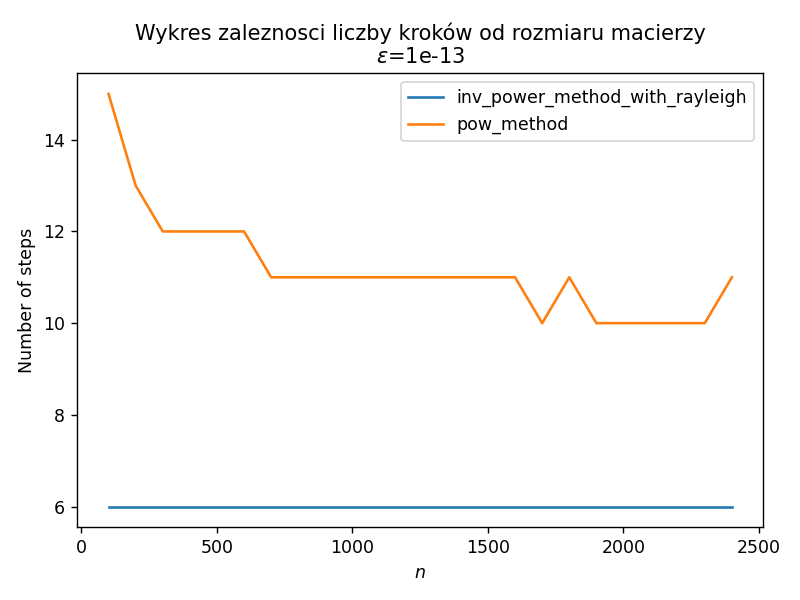

In [204]:
fig = plt.figure()
plt.plot(data_pow[:, 0], data_pow[:, 2], label='inv_power_method_with_rayleigh')
plt.plot(data_pow[:, 0], data_pow[:, 4], label='pow_method')
plt.title(f'Wykres zaleznosci liczby kroków od rozmiaru macierzy\n$\epsilon$={epsilon}')
plt.xlabel('$n$')
plt.ylabel('Number of steps')
# plt.xscale('log')
plt.legend()
fig.tight_layout()
plt.show()

Dla coraz większych wartości $n$ zwykła metoda potęgowa potrzebuje coraz mniejszej liczby kroków aby osiągnąć konkretną dokładność.

Natomiast metoda z ilorazem Rayleigha posiada o wiele lepszą zbieżność, dla każdej wartości $n$ liczba potrzebnych kroków jest tak samo mała i wynosi 6. Metoda ta bardzo dobrze zachowuje się dla dużych macierzy.

In [198]:
data = []
epsilons = np.logspace(-1, -35, -1 - (-35) + 1, base=2)

funs = [lambda A, x_0, buff, epsilon: inv_power_method_with_rayleigh(A, x_0=x_0, use_inv=False, epsilon=epsilon, epsilon_buff=buff), 
        lambda A, x_0, buff, epsilon: power_method(A, x_0=x_0, epsilon=epsilon, epsilon_buff=buff)]
names = ['inv_power_method_with_rayleigh', 'power_method']

n = 20

for epsilon in epsilons:
    d = [f'{nstr(mpf(epsilon), 3)}']
    M = rand_symm(n)
    buffs = [[], []]
    x_0 = np.random.rand(n, 1)
    for f, name, buff in zip(funs, names, buffs):
        f(M, x_0, buff, epsilon)
        d += [name, str(len(buff))]
    data.append(d)

pd.DataFrame(data, columns=['Epsilon', 'Function', 'Number of steps', 'Function', 'Number of steps'])

,Epsilon,Function,Number of steps,Function,Number of steps
0,0.5,inv_power_method_with_rayleigh,4,power_method,3
1,0.25,inv_power_method_with_rayleigh,3,power_method,3
2,0.125,inv_power_method_with_rayleigh,4,power_method,4
3,0.0625,inv_power_method_with_rayleigh,4,power_method,4
4,0.0313,inv_power_method_with_rayleigh,4,power_method,4
5,0.0156,inv_power_method_with_rayleigh,5,power_method,5
6,0.00781,inv_power_method_with_rayleigh,5,power_method,5
7,0.00391,inv_power_method_with_rayleigh,5,power_method,5
8,0.00195,inv_power_method_with_rayleigh,5,power_method,6
9,0.000977,inv_power_method_with_rayleigh,5,power_method,6


In [ ]:
data_pow = pd.DataFrame(data, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]']).to_numpy()
data_pow[:, [0, 2, 4]] = data_pow[:, [0, 2, 4]].astype(f64)

In [193]:
data_pow = pd.DataFrame(data, columns=['n', 'Function', 'Time[ms]', 'Function', 'Time[ms]']).to_numpy()
data_pow[:, [0, 2, 4]] = data_pow[:, [0, 2, 4]].astype(f64)

<IPython.core.display.Javascript object>


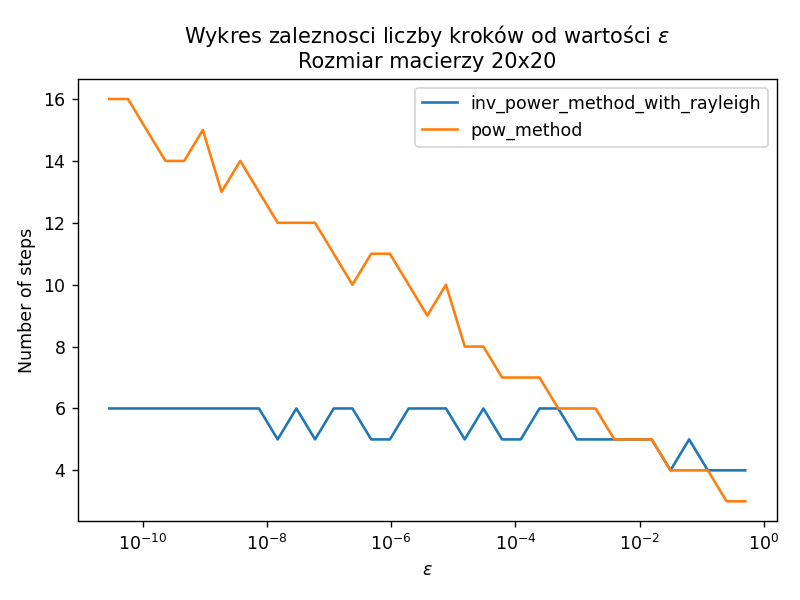

In [196]:
fig = plt.figure()
plt.plot(data_pow[:, 0], data_pow[:, 2], label='inv_power_method_with_rayleigh')
plt.plot(data_pow[:, 0], data_pow[:, 4], label='pow_method')
plt.title(f'Wykres zaleznosci liczby kroków od wartości $\epsilon$\nRozmiar macierzy {n}x{n}')
plt.xlabel('$\epsilon$')
plt.ylabel('Number of steps')
plt.xscale('log')
plt.legend()
fig.tight_layout()
plt.show()

Dla coraz mniejszych wartości $\epsilon$ zwykła metoda potęgowa potrzebuje coraz większą liczbę kroków (przyrost jest liniowy).

Natomiast metoda z ilorazem Rayleigha posiada o wiele lepszą zbieżność, z każdym krokiem liczba dokładnych cyfr wzrasta trzykrotnie, co dla tak stosunkowo dużych wartości $\epsilon$ liczba potrzebnych kroków jest praktucznie stała.